In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [54]:
dataset = FashionMNIST(root = './', train=True,transform=ToTensor(), download=True)
test_ds = FashionMNIST(root= './', train= False,transform=ToTensor())

In [55]:
print(len(dataset))
print(len(test_ds))

60000
10000


## Dataset and Dataloader

In [56]:
dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [57]:
validation_split = 0.1
val_size = int(len(dataset) * validation_split)
train_size = len(dataset) - val_size

train_ds,val_ds = random_split(dataset,[train_size,val_size])

In [58]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle= True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle= True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle= True, num_workers=4, pin_memory=True)

## Visulasing a batch of image

Shape:  torch.Size([64, 1, 28, 28])


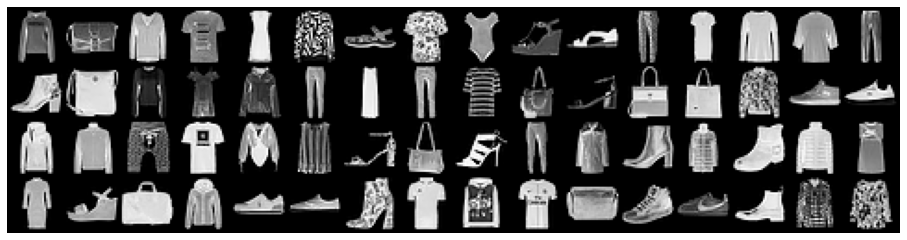

In [59]:
for img,labels in train_loader:
  plt.figure(figsize=(16,8))
  print("Shape: ",img.shape)
  plt.axis('off')
  plt.imshow(make_grid(img,nrow=16).permute(1,2,0))
  break

## Building The Model

In [60]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Fashion_mnist(nn.Module):

  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), #output : 64 * 14 * 14

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(), 
        nn.MaxPool2d(2, 2), #output : 128 * 7 * 7


        nn.Flatten(),
        nn.Linear(128*7*7, 512),
        nn.ReLU(),
        nn.Linear(512,10)
        )

  def forward(self,xb):
    out = self.network(xb)
    return out

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
     print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [61]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [62]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Using GPU

In [63]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [64]:
device = get_default_device()
device

device(type='cuda')

In [65]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [66]:
model = to_device(Fashion_mnist(), device)

In [67]:
model

Fashion_mnist(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten()
    (11): Linear(in_features=6272, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [68]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [69]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

## Training The model

In [70]:
history = fit(10,0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

Epoch [0], train_loss: 0.4269, val_loss: 0.3016, val_acc: 0.8813
Epoch [1], train_loss: 0.2510, val_loss: 0.2535, val_acc: 0.8991
Epoch [2], train_loss: 0.2031, val_loss: 0.2426, val_acc: 0.9065
Epoch [3], train_loss: 0.1647, val_loss: 0.1964, val_acc: 0.9259
Epoch [4], train_loss: 0.1343, val_loss: 0.1982, val_acc: 0.9281
Epoch [5], train_loss: 0.1073, val_loss: 0.2147, val_acc: 0.9286
Epoch [6], train_loss: 0.0818, val_loss: 0.2350, val_acc: 0.9243
Epoch [7], train_loss: 0.0605, val_loss: 0.2774, val_acc: 0.9291
Epoch [8], train_loss: 0.0453, val_loss: 0.2941, val_acc: 0.9282
Epoch [9], train_loss: 0.0364, val_loss: 0.3002, val_acc: 0.9238


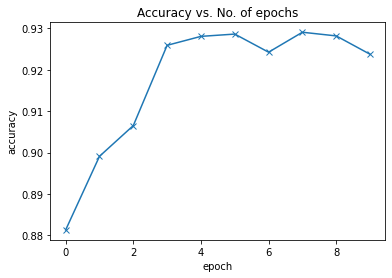

In [71]:
plot_accuracies(history)

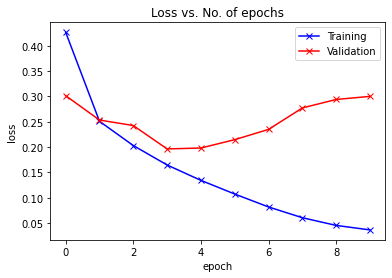

In [72]:
plot_losses(history)

## Evaluating on test data

In [74]:
evaluate(model,test_loader)

{'val_acc': 0.9238654375076294, 'val_loss': 0.3165999948978424}